# Demo Template Matching using Normalized Cross Correlation

In this lesson we show the template matching method to localize a given pattern in a image. 
We use the NCC - Normalized Cross-Correlation.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys,os


## Image input and template extraction

This code reads a gray scale image and extracts a piece as template. 

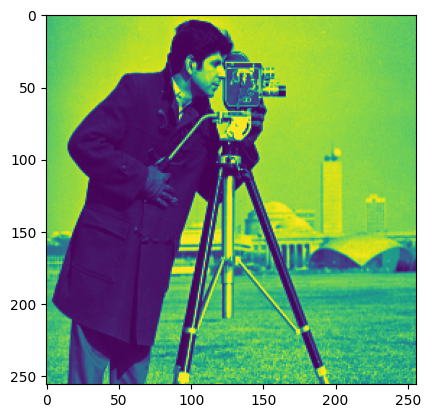

In [4]:
import numpy as np

f = mpimg.imread('../../figures/cameraman.tif')

plt.imshow(f)


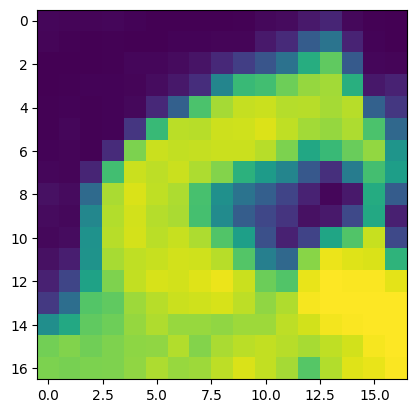

In [5]:
(r0,c0) = 25,106
N = 17
t = f[r0:r0+N,c0:c0+N]
plt.imshow(t)


In [10]:
def normalize(f, range=[0,255]):

    f = np.asarray(f)
    range = np.asarray(range)
    if f.dtype.char in ['D', 'F']:
        raise Exception('error: cannot normalize complex data')
    faux = np.ravel(f).astype(float)
    minimum = faux.min()
    maximum = faux.max()
    lower = range[0]
    upper = range[1]
    if upper == lower:
        g = np.ones(f.shape) * maximum
    if minimum == maximum:
        g = np.ones(f.shape) * (upper + lower) / 2.
    else:
        g = (faux-minimum)*(upper-lower) / (maximum-minimum) + lower
    g = g.reshape(f.shape)

    if f.dtype == np.uint8:
        if upper > 255: 
            raise Exception('normalize: warning, upper valuer larger than 255. Cannot fit in uint8 image')
    if lower == 0 and upper == 255:
        g = g.astype(np.uint8)
    else:
        g = g.astype(f.dtype) # set data type of result the same as the input image
    return g

In [12]:
def pconv(f,h):
    import numpy as np

    h_ind=np.nonzero(h)
    f_ind=np.nonzero(f)
    if len(h_ind[0])>len(f_ind[0]):
        h,    f    = f,    h
        h_ind,f_ind= f_ind,h_ind

    gs = np.maximum(np.array(f.shape),np.array(h.shape))
    if (f.dtype == 'complex') or (h.dtype == 'complex'):
        g = np.zeros(gs,dtype='complex')
    else:
        g = np.zeros(gs)

    f1 = g.copy()
    f1[f_ind]=f[f_ind]      

    if f.ndim == 1:
        (W,) = gs
        col = np.arange(W)
        for cc in h_ind[0]:
            g[:] += f1[(col-cc)%W] * h[cc]

    elif f.ndim == 2:
        H,W = gs
        row,col = np.indices(gs)
        for rr,cc in np.transpose(h_ind):
            g[:] += f1[(row-rr)%H, (col-cc)%W] * h[rr,cc]

    else:
        Z,H,W = gs
        d,row,col = np.indices(gs)
        for dd,rr,cc in np.transpose(h_ind):
            g[:] += f1[(d-dd)%Z, (row-rr)%H, (col-cc)%W] * h[dd,rr,cc]
    return g

## Direct Image Cross Correlation

Direct image correlation is not a efficient procedure as gray levels and illuminations issues 
contain strong variations. 

$$    
    c(u,v) = \sum_{x,y} f(x,y)t(x-u,y-v)
$$

found best match at (152,210)



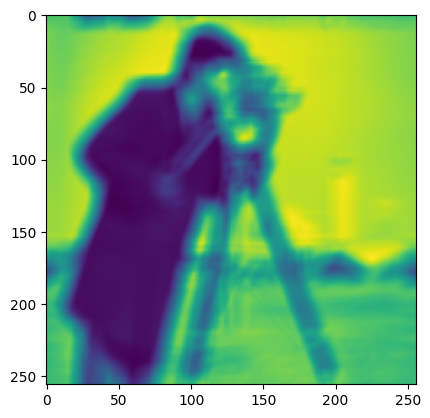

In [14]:
f=f.astype(np.float16)
t=t.astype(np.float16)
c = pconv(f, t[::-1,::-1]) 
plt.imshow(normalize(c,[0,255]))
(row,col) = np.unravel_index(np.argmax(c),c.shape) - np.array([N-1,N-1])    
print('found best match at (%3.0f,%3.0f)\n' %(row,col))

# NCC - Normalized Cross Correlation

It is necessary to subtract the image from it´s mean in order to make 
all regions(light or dark) receive the same importance value.
The normalization factor can be used to improve the model detection.

$$    
    \gamma(u,v) = \frac{\sum_{x,y} [ f(x,y) - \overline{f}_{u,v}][t(x-u,y-v) - \overline{t}]}{\sqrt{\sum_{x,y}[f(x,y)-\overline{f}_{u,v}]^2 \sum_{x,y}[t(x-u,y-u)-\overline{t}]^2}}
$$

If our concert in only to find the maximum response of $\gamma$, 
the above equation can be simplified in:

$$    \gamma_1(u,v) = \frac{\sum_{x,y} [f(x,y) t'(x-u,y-v)]}{\sqrt{\sum_{x,y}[f(x,y)-\overline{f}_{u,v}]^2}}
$$
where $t'$ is the template subtracted from its mean.

The denominator can be further simplified:

$$
    \gamma_1(u,v) = \frac{\sum_{x,y} [f(x,y) t'(x-u,y-v)]}{\sqrt{\sum_{x,y}f^2(x,y)-\frac{1}{n}[\sum_{x,y}f(x,y)]^2}}
$$

Using periodic convolution, the above equation can result in:

$$    
    \gamma_1 = \frac{f \ast (\breve{t}-\overline{t})} {\sqrt{[f^2 \ast i] - \frac{1}{n}(f \ast i)^2}}
$$

In [27]:
import math 
n = t.size
t1 = t[::-1, ::-1] - t.mean()
num = pconv(f, t1)
i = np.ones(t.shape)
fm2 = pconv(f * f, i)
fm = pconv(f, i)
arg = np.maximum(fm2 - fm * fm / n, 0)  # Replace negative values with zeros
den = np.sqrt(arg)

In [33]:
# Replace zero values in den with a small positive value
den[den == 0] = np.finfo(float).eps

gamma1 = num / den

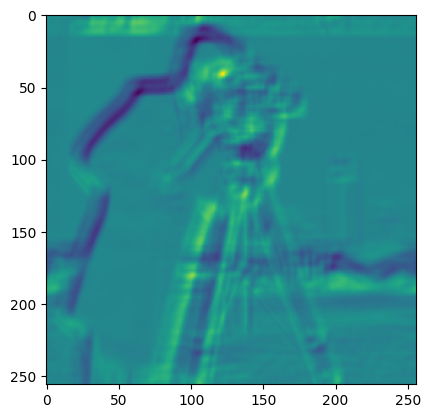

In [34]:
plt.imshow(normalize(num)) # , title='numerator'


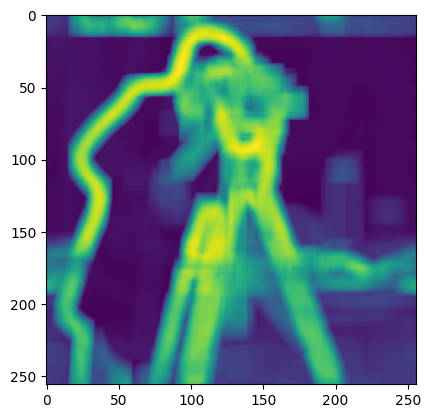

In [35]:
plt.imshow(normalize(den)) # , title='denominator'


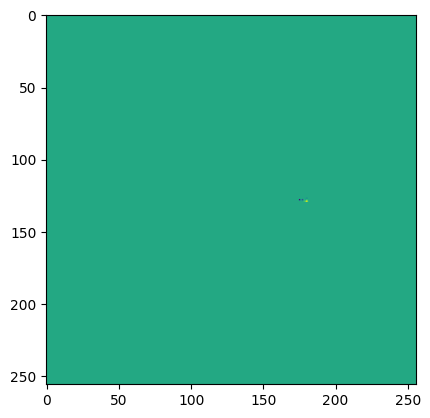

In [37]:
plt.imshow(normalize(gamma1)) # , title='gamma1'


In [40]:
(row,col) = np.unravel_index(np.argmax(gamma1),gamma1.shape) - np.array([N-1,N-1])
print('found best match at (%3.0f,%3.0f)\n' %(row,col))


found best match at (113,164)



# See Also

- [iapconv](../src/pconv.ipynb) - Periodic convolution

# Referências

1. [J.P. Lewis - Fast Normalized Cross-Correlation -  Vision interface, 1995](http://www.academia.edu/download/3607630/10.1.1.21.6062.pdf)

2. [K Briechle; U. D. Hanebeck - Template Matching using Fast NCC - Proc. SPIE 4387, Optical Pattern Recognition XII, 2001](http://i81pc23.itec.uni-karlsruhe.de/Publikationen/SPIE01_BriechleHanebeck_CrossCorr.pdf)